In [5]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [6]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [7]:
# Investiagte the features of the node of graph
data[0].x

# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

tensor([[-0.7700]])

In [8]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

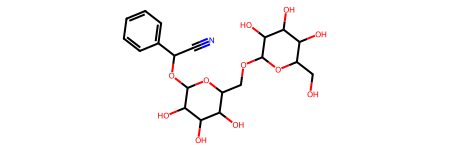

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [11]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 0.8529620170593262
Epoch 200 | Train Loss 1.1274889707565308
Epoch 300 | Train Loss 0.3205885887145996
Epoch 400 | Train Loss 0.2282666712999344
Epoch 500 | Train Loss 0.3806729316711426
Epoch 600 | Train Loss 0.23642598092556
Epoch 700 | Train Loss 0.07051455229520798
Epoch 800 | Train Loss 0.17124061286449432
Epoch 900 | Train Loss 0.1590157002210617
Epoch 1000 | Train Loss 0.07476065307855606
Epoch 1100 | Train Loss 0.04038993641734123
Epoch 1200 | Train Loss 0.12332872301340103
Epoch 1300 | Train Loss 0.05092313885688782
Epoch 1400 | Train Loss 0.026280106976628304
Epoch 1500 | Train Loss 0.0175775233656168
Epoch 1600 | Train Loss 0.0356731154024601
Epoch 1700 | Train Loss 0.0107906274497509
Epoch 1800 | Train Loss 0.05112229287624359
Epoch 1900 | Train Loss 0.12436607480049133


<Axes: >

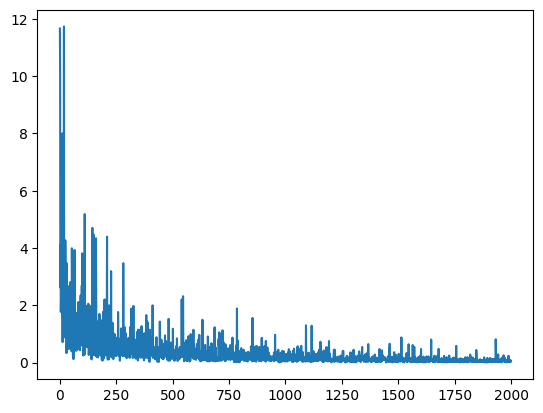

In [12]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(losses_float)
plt

In [13]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,0.940,0.409338
1,-6.237,-2.796636
2,-2.540,-2.714082
3,-5.680,-5.760009
4,-2.460,-1.828137
...,...,...
59,-1.890,-1.403911
60,-2.218,-4.804687
61,-3.583,-0.986221
62,-2.580,-2.299780


<Axes: xlabel='y_real', ylabel='y_pred'>

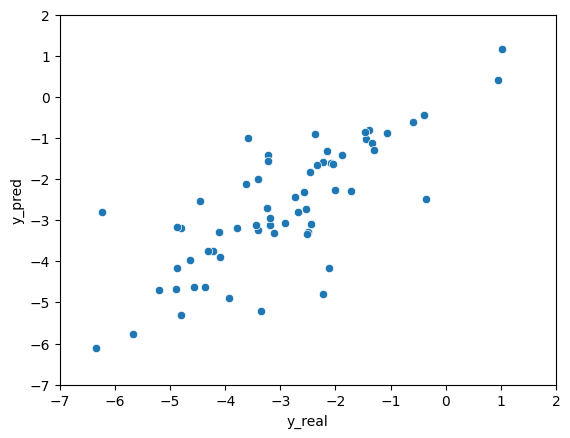

In [14]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt